In [2]:
from google.colab import files
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

uploaded = files.upload()

for filename in uploaded.keys():
  df = pd.read_csv(filename)
  print(f"Файл '{filename}' загружен. Количество строк: {len(df)}")


Saving cookie_cats 2.csv to cookie_cats 2.csv
Файл 'cookie_cats 2.csv' загружен. Количество строк: 90189


In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [4]:
df["userid"].count() == df["userid"].nunique()

True

### Все пользователи уникальны.

In [5]:
display(df.groupby("version")[["userid"]].nunique())
n2, n1 = df.version.value_counts()

,userid
version,
gate_30,44700
gate_40,45489


### Образцы примерно одинаковы.


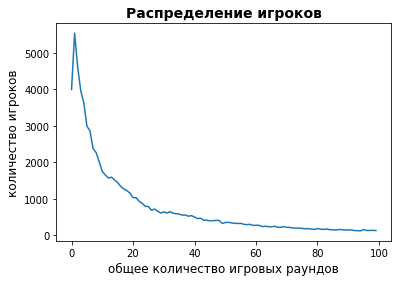

In [ ]:
plot_df = df.groupby("sum_gamerounds")["userid"].count()
ax = plot_df.head(100).plot()
plt.title("Распределение игроков", fontweight="bold", size=14)
plt.xlabel("общее количество игровых раундов", size=12)
plt.ylabel("количество игроков", size=12)
plt.show()

In [ ]:
df.query("sum_gamerounds == 0").userid.count()

3994

### Распространенным показателем в индустрии видеоигр для оценки того, насколько интересна игра, является удержание: процент игроков, которые возвращаются и играют в игру через 1 и 7 дней после ее установки. Чем выше коэффициент удержания, тем легче удержать игроков.

In [ ]:
df_retention = df[["retention_1","retention_7"]].mean()*100
print(f"Коэффициент удержания за 1 день: {round(df_retention[0],2)}% \
      \nКоэффициент удержания за 7 дней: {round(df_retention[1],2)}%")

Коэффициент удержания за 1 день: 44.52%       
Коэффициент удержания за 7 дней: 18.61%


In [ ]:
df.query('version == "gate_30" and retention_1 == False').sum_gamerounds
display(stats.kstest(df.sum_gamerounds, 'norm'))
display(stats.kstest(df.sum_gamerounds, 'expon'))
display(stats.kstest(df.sum_gamerounds, 'binom', args=(1500, 0.16)))

KstestResult(statistic=0.8715607041848303, pvalue=0.0, statistic_location=2, statistic_sign=-1)

KstestResult(statistic=0.7934532380996653, pvalue=0.0, statistic_location=3, statistic_sign=-1)

KstestResult(statistic=0.9398360749415627, pvalue=0.0, statistic_location=200, statistic_sign=1)

In [ ]:
df.query('version == "gate_30" and retention_1 == True and retention_7 == True').userid.count()

6676

In [ ]:
df.query('version == "gate_40" and retention_1 == True and retention_7 == True').userid.count()

6506

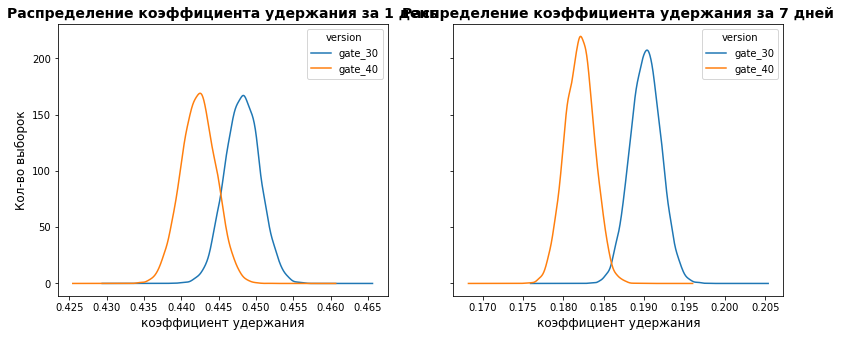

In [ ]:
boot_1d = pd.DataFrame([df.sample(frac=1, replace=True).groupby(
    'version')['retention_1'].mean() for _ in range(10000)])
boot_7d = pd.DataFrame([df.sample(frac=1, replace=True).groupby(
    'version')['retention_7'].mean() for _ in range(10000)])

# Kernel Density Estimate plot of the bootstrap distributions
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13, 5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("коэффициент удержания", size=12)
ax1.set_ylabel("Кол-во выборок", size=12)
ax1.set_title("Распределение коэффициента удержания за 1 день",
              fontweight="bold", size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("коэффициент удержания", size=12)
ax2.set_title("Распределение коэффициента удержания за 7 дней",
              fontweight="bold", size=14)
plt.show()

### Два приведенных выше распределения представляют собой бутстрапную неопределенность относительно того, каким может быть базовое 1-дневное и 7-дневное удержание для двух групп A/B. Просто взглянув на этот график, мы можем увидеть, что, кажется, есть некоторое указание на разницу, хотя и небольшую. Давайте увеличим разницу.

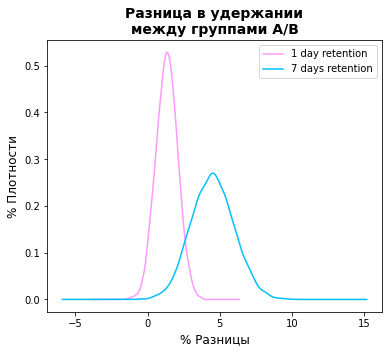

In [ ]:
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% Разницы",size=12)
ax1.set_ylabel("% Плотности",size=12)
ax1.set_title("Разница в удержании\nмежду группами A/B", fontweight="bold", size=14)
plt.legend()
plt.show()

### Из этого графика видно, что наиболее вероятная процентная разница составляет около 1-2% для удержания на 1 день. Для 7-дневного удержания наиболее вероятная процентная разница составляет около 2-5%. Причем большая часть распределения выше 0%, в пользу 30 уровня. Определим вероятность, что разница выше 0%.

In [ ]:
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

print(f"Вероятность того, что 1-дневное удержание выше, когда ворота находятся на уровне 30: {round(prob_1,2)*100}% \
      \nВероятность того, что 7-дневное удержание выше, когда ворота находятся на уровне 30: {(prob_7)*100}% ")

# Результат показывает, что с вероятностью 99,8% 7-дневное удержание выше, когда порог равен 30, чем когда он равен 40. Таким образом для того, чтобы сохранить высокими показатели удержаний как на 1-ый, так и на 7-ой день, то нам не следует перемещать "гейт" с 30-го на 40-ой уровень. 